In [7]:
#GA code
from utils import *
class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        
    @property
    def population(self):
        return self.__population
    
    def initialisation(self):
        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problParam)
            self.__population.append(c)
        self.evaluation()
    
    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problParam['function'](c.repres, self.__problParam['network'])
            
    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness > best.fitness):
                best = c
        return best
        
    def worstChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness < best.fitness):
                best = c
        return best

    def selection(self):
        pos1 = randint(0, self.__param['popSize'] - 1)
        pos2 = randint(0, self.__param['popSize'] - 1)
        if (self.__population[pos1].fitness > self.__population[pos2].fitness):
            return pos1
        else:
            return pos2 
        
    
    def oneGeneration(self):
        newPop = []
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        newPop = [self.bestChromosome()]
        for _ in range(self.__param['popSize'] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()
        
    def oneGenerationSteadyState(self):
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            off.fitness = self.__problParam['function'](off.repres,problParam['network'])
            worst = self.worstChromosome()
            if (off.fitness < worst.fitness):
                worst = off
    
    def oneGenerationSorted(self):
        self.__population.sort(key=lambda x: x.fitness)
        top = self.__population[-1*self.__param['popSize']:]
        saved = top[int(-1*self.__param['B']*len(top)):]
        newgen = []
        for i in range(0,len(top),2):
            c1 = top[i].crossover(top[i+1])
            c2 = top[i+1].crossover(top[i])
            newgen.append(c1)
            newgen.append(c2)
        n = int(self.__problParam['mutationRate']*len(newgen))
        for i in range(n):
            j = randint(0,len(newgen)-1)
            newgen[j].mutation()
        
        self.__population = newgen + saved
        self.evaluation()

In [8]:
#Evaluation function
def modularity(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']  
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if (communities[i] == communities[j]):
               Q += (mat[i][j] - degrees[i] * degrees[j] / M)
    return Q * 1 / M



In [9]:
#Load the network
def getPath(name):
    crtDir =  os.getcwd()
    filePath = os.path.join(crtDir, 'Data', name, name+'.gml')
    return filePath
'''
import os 
crtDir =  os.getcwd()
filePath = os.path.join(crtDir, 'lab03_fcOptimisGA', 'communityDetection', 'data', 'net.in')
network = readNet(filePath)
'''
network  = readNetwork(getPath('karate'))

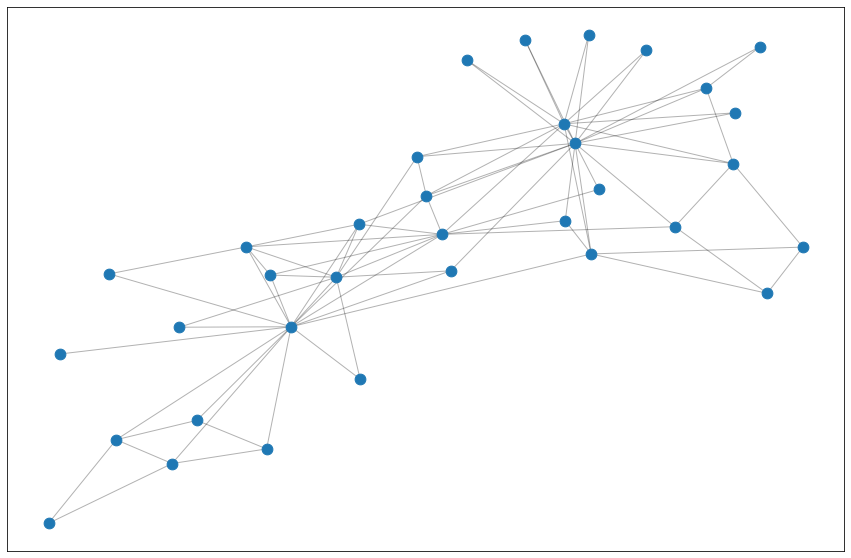

In [10]:
#Plot the network
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import warnings 


warnings.simplefilter('ignore')
A=np.matrix(network['mat'])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(15, 10))  # image is 15 x 10 inches 
nx.draw_networkx_nodes(G, pos, node_size=115, cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)


In [11]:
from utils import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import warnings

def mainFunction(network, gaParam):
    problParam = {'mutationRate':0.5,'min' : 1, 'max' : network['noNodes'], 'function' : modularity, 'noDim' : network['noNodes'],
              'noBits' : network['noNodes'], 'network' : network, 'initializeFactor' : 0.2,'crossoverRate' : 0.2}
    ga = GA(gaParam, problParam)
    ga.initialisation()
    ga.evaluation()
    bestFitnessOverTime = []
    generations = []
    for g in range(gaParam['noGen']):
        if g%50 == 0:
            print("Reached generation : " + str(g))
        best = ga.bestChromosome().repres
        ga.oneGenerationSorted()
        dict = {}
        for v in best:
            dict[v] = None
        bestFitnessOverTime.append(ga.bestChromosome().fitness)
        generations.append(g)
        
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.title("Fitness evolution over time")
    plt.plot(generations,bestFitnessOverTime)
    
    print('Community of each node:' + str(ga.bestChromosome().repres)+'\n')    
    A=np.matrix(network["mat"])
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G) 
    plt.figure(figsize=(15, 10))  
    nx.draw_networkx_nodes(G, pos, node_size = 100, cmap = plt.cm.RdYlBu, node_color = ga.bestChromosome().repres)
    nx.draw_networkx_edges(G, pos, alpha = 0.3)
    plt.show(G)


In [ ]:
#Main
gaParam = {'popSize' : 100, 'noGen' : 200,'B' : 0.1}
mainFunction(network, gaParam)


Reached generation : 0
Reached generation : 50
Reached generation : 100
Reached generation : 150
